In [1]:
%pip install osmium

  Using cached osmium-4.0.2-cp313-cp313-macosx_11_0_arm64.whl.metadata (3.5 kB)
  Using cached charset_normalizer-3.4.2-cp313-cp313-macosx_10_13_universal2.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
Using cached osmium-4.0.2-cp313-cp313-macosx_11_0_arm64.whl (1.1 MB)
Using cached charset_normalizer-3.4.2-cp313-cp313-macosx_10_13_universal2.whl (199 kB)
Using cached idna-3.10-py3-none-any.whl (70 kB)
Using cached urllib3-2.4.0-py3-none-any.whl (128 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [osmium]2m2/5 [charset_normalizer]
Note: you may need to restart the kernel to use updated packages.


In [9]:
import osmium

class POIHandler(osmium.SimpleHandler):
    def __init__(self):
        super(POIHandler, self).__init__()
        self.pois = []

    def node(self, n):
        if 'name' in n.tags and 'amenity' in n.tags: # Example: filtering for nodes with amenity tag
            self.pois.append({
                'id': n.id,
                'lon': n.location.lon,
                'lat': n.location.lat,
                'tags': dict(n.tags) # Convert tags to a regular dictionary
            })

    def way(self, w):
        # POIs are typically nodes, but some might be ways (e.g., a park boundary)
        # You can add logic here if you expect POIs to be ways
        pass

    def relation(self, r):
        # POIs are rarely relations, but can be (e.g., a complex building with multiple parts)
        # You can add logic here if you expect POIs to be relations
        pass

# Create an instance of your handler
handler = POIHandler()

# Apply the handler to your .osm.pbf file
try:
    handler.apply_file("data/germany_pois_filtered.osm.pbf")
except osmium.InvalidDataError as e:
    print(f"Error reading file: {e}")
    print("This might happen if the file is corrupted or not a valid OSM PBF.")
    exit()

# Now you can work with the extracted POIs
print(f"Found {len(handler.pois)} POIs.")

# Print the first few POIs
for i, poi in enumerate(handler.pois[:5]):
    print(f"POI {i+1}:")
    print(f"  ID: {poi['id']}")
    print(f"  Location: ({poi['lat']}, {poi['lon']})")
    print(f"  Tags: {poi['tags']}")
    print("-" * 20)

# You can further process 'handler.pois' to, for example, convert it to a pandas DataFrame
# import pandas as pd
# df = pd.DataFrame(handler.pois)
# print(df.head())

Found 437279 POIs.
POI 1:
  ID: 359460
  Location: (50.9155914, 6.9412465)
  Tags: {'addr:city': 'Köln', 'addr:country': 'DE', 'addr:housenumber': '107', 'addr:postcode': '50969', 'addr:street': 'Höninger Weg', 'amenity': 'fast_food', 'changing_table': 'no', 'check_date:opening_hours': '2024-07-02', 'contact:website': 'https://www.papapizza.de/', 'cuisine': 'pizza', 'diet:vegan': 'no', 'diet:vegetarian': 'yes', 'drive_through': 'no', 'indoor_seating': 'yes', 'name': 'Papa-Pizza', 'opening_hours:signed': 'no', 'outdoor_seating': 'no', 'wheelchair': 'limited'}
--------------------
POI 2:
  ID: 359829
  Location: (50.9049155, 6.9639535)
  Tags: {'amenity': 'car_rental', 'brand': 'STARCAR', 'brand:wikidata': 'Q123031847', 'name': 'STARCAR'}
--------------------
POI 3:
  ID: 359832
  Location: (50.9052005, 6.9639347)
  Tags: {'amenity': 'restaurant', 'name': 'Hartis Cafe', 'opening_hours': 'Mo,Tu 11:30-16:00', 'wheelchair': 'yes'}
--------------------
POI 4:
  ID: 2455376
  Location: (50.00

Reading POIs from data/germany_pois_filtered.osm.pbf...
Finished reading 1051901 potential POIs.

GeoDataFrame created successfully!
       id        lon        lat               name     amenity  shop tourism  \
0  274282  11.108173  47.514584  Farchant-Burgrain        None  None    None   
1  342906   8.376069  48.993738     Bulacher Kreuz        None  None    None   
2  359460   6.941247  50.915591         Papa-Pizza   fast_food  None    None   
3  359829   6.963953  50.904916            STARCAR  car_rental  None    None   
4  359832   6.963935  50.905200        Hartis Cafe  restaurant  None    None   

  leisure cuisine                                           all_tags  \
0    None    None  {'highway': 'motorway_junction', 'name': 'Farc...   
1    None    None  {'highway': 'motorway_junction', 'name': 'Bula...   
2    None   pizza  {'addr:city': 'Köln', 'addr:country': 'DE', 'a...   
3    None    None  {'amenity': 'car_rental', 'brand': 'STARCAR', ...   
4    None    None  {'ameni

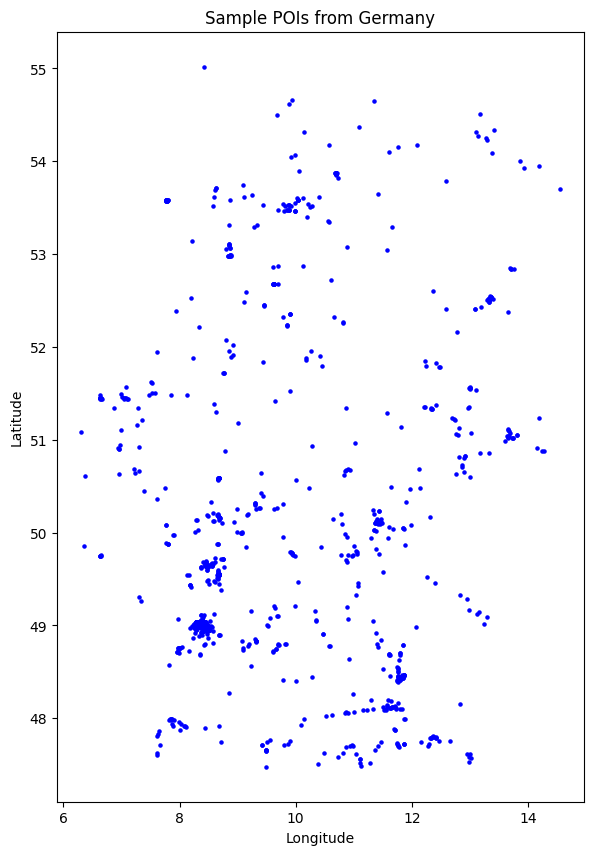

In [12]:
import osmium
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

class POIHandler(osmium.SimpleHandler):
    def __init__(self):
        super(POIHandler, self).__init__()
        self.pois_data = []

    def node(self, n):
        # We'll include more tags for better representation in the GeoDataFrame
        # You can adjust this filtering based on what constitutes a "POI" for you
        if 'name' in n.tags and n.location.valid: # Ensure location is valid
            self.pois_data.append({
                'id': n.id,
                'lon': n.location.lon,
                'lat': n.location.lat,
                'name': n.tags.get('name'),
                'amenity': n.tags.get('amenity'),
                'shop': n.tags.get('shop'),
                'tourism': n.tags.get('tourism'),
                'leisure': n.tags.get('leisure'),
                'cuisine': n.tags.get('cuisine'),
                # Add any other relevant tags you want to include as columns
                'all_tags': dict(n.tags) # Keep all original tags in a dictionary
            })

    def way(self, w):
        # For ways, if you want them as POIs, you might consider their centroid
        # or a representative point, but for typical POIs (points of interest),
        # nodes are usually sufficient.
        pass

    def relation(self, r):
        # Similar to ways, less common for typical POIs.
        pass

# --- Main execution ---
file_path = "data/germany_pois_filtered.osm.pbf"
handler = POIHandler()

print(f"Reading POIs from {file_path}...")
try:
    handler.apply_file(file_path)
    print(f"Finished reading {len(handler.pois_data)} potential POIs.")
except osmium.InvalidDataError as e:
    print(f"Error reading file: {e}")
    print("This might happen if the file is corrupted or not a valid OSM PBF.")
    exit()

# Create a Pandas DataFrame first
if not handler.pois_data:
    print("No POI data found to create a DataFrame.")
    exit()

df = pd.DataFrame(handler.pois_data)

# Create a 'geometry' column from 'lon' and 'lat'
# This creates Shapely Point objects
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]

# Create the GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326") # WGS84, standard for GPS coordinates

print("\nGeoDataFrame created successfully!")
print(gdf.head())
print(f"\nGeoDataFrame has {len(gdf)} entries.")
print(gdf.info())

# Optional: Save to a spatial file format (e.g., GeoJSON, Shapefile)
output_geojson_path = "germany_pois_filtered.geojson"
try:
    gdf.to_file(output_geojson_path, driver="GeoJSON")
    print(f"\nPOIs saved to {output_geojson_path}")
except Exception as e:
    print(f"Error saving GeoJSON: {e}")

#Optional: Plotting (requires matplotlib)
import matplotlib.pyplot as plt
if not gdf.empty:
    print("\nPlotting the first 1000 POIs (if available)...")
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    gdf.head(1000).plot(ax=ax, marker='o', color='blue', markersize=5)
    plt.title('Sample POIs from Germany')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
else:
    print("\nGeoDataFrame is empty, no plot generated.")

In [ ]:
import osmium
import pandas as pd
import geopandas
from shapely.geometry import Point

class POIHandler(osmium.SimpleHandler):
    def __init__(self):
        super(POIHandler, self).__init__()
        self.poi_data = []

    def node(self, n):
        if 'name' in n.tags and 'amenity' in n.tags and n.location.valid:
            poi_info = {
                'id': n.id,
                'lon': n.location.lon,
                'lat': n.location.lat,
                'amenity': n.tags.get('amenity'), # Get specific tags
                'name': n.tags.get('name')
            }
            # Add all other tags to the dictionary directly or in a nested dictionary
            for k, v in n.tags:
                if k not in ['amenity', 'name']: # Avoid duplicating already extracted tags
                    poi_info[k] = v
            self.poi_data.append(poi_info)

    def way(self, w):
        # Ways can also be POIs (e.g., parks, buildings).
        # For simplicity, this example focuses on node-based POIs.
        # If you need to handle ways as POIs, you'd need to calculate
        # their centroid or represent them as polygons, which is more complex.
        pass

    def relation(self, r):
        # Relations can also define POIs (e.g., complex multi-part buildings).
        # Similar to ways, handling them as points for a POI GeoDataFrame
        # might require centroid calculation.
        pass

# File path
pbf_file = "data/germany_pois_amenities.osm.pbf"

# Create an instance of your handler
handler = POIHandler()

# Apply the handler to your .osm.pbf file
print(f"Processing file: {pbf_file}...")
try:
    handler.apply_file(pbf_file, locations=True) # locations=True is crucial for getting lat/lon for nodes
    print("File processing complete.")
except osmium.InvalidDataError as e:
    print(f"Error reading file: {e}")
    print("This might happen if the file is corrupted or not a valid OSM PBF.")
    exit()
except FileNotFoundError:
    print(f"Error: The file '{pbf_file}' was not found. Please check the path.")
    exit()

# Convert the list of POI dictionaries to a pandas DataFrame
if not handler.poi_data:
    print("No POIs found with the specified filters.")
    # Create an empty GeoDataFrame if no data is found to avoid errors later
    gdf = geopandas.GeoDataFrame(columns=['id', 'lon', 'lat', 'amenity', 'name', 'geometry'], crs="EPSG:4326")
else:
    df = pd.DataFrame(handler.poi_data)

    # Create Shapely Point objects from 'lon' and 'lat' columns
    geometry = geopandas.points_from_xy(df['lon'], df['lat'])

    # Create the GeoDataFrame
    # We use EPSG:4326 for WGS84 geographic coordinates (latitude and longitude)
    gdf = geopandas.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

print(f"GeoDataFrame created with {len(gdf)} POIs.")

# Display the first few rows of the GeoDataFrame
print("\nFirst 5 rows of the GeoDataFrame:")
print(gdf.head())

# Display GeoDataFrame info
print("\nGeoDataFrame Info:")
gdf.info()

# Example: Save the GeoDataFrame to a GeoPackage file
output_gpkg = "germany_pois_filtered.gpkg"
try:
    if not gdf.empty:
        gdf.to_file(output_gpkg, driver="GPKG")
        print(f"\nPOIs saved to {output_gpkg}")
    else:
        print("GeoDataFrame is empty, not saving to file.")
except Exception as e:
    print(f"Error saving to GeoPackage: {e}")

Processing file: data/germany_pois_amenities.osm.pbf...
File processing complete.


KeyboardInterrupt: 

: 